In [1]:
import importlib
from pathlib import Path

import anndata as ad
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell

from clustering import subcluster

importlib.reload(subcluster)

if True:
    from clustering.subcluster import (
        ClusteringResult,
        ClusteringResultManager,
        plot_clustering_heatmap_2,
        run_clustering,
        update_geojson_from_clustering_result,
    )

InteractiveShell.ast_node_interactivity = "all"


# Demo Data


In [2]:
# Load data
data_df = pd.read_csv("input/data_demo.csv")
data_df.head()
data_df.columns

data_df["cell_id"] = data_df["core_id"] + "_c" + data_df["cell_label"].astype(str)

,core_id,cell_label,cell_size,y_cent,x_cent,tma,CD45,CD3e,CD8,CD4,...,CD20,CD68,CD163,CD16,CD11b,MPO,Cytokeratin,CD31,Podoplanin,aSMA
0,RCC-TMA609(reg_4x5)-dst=reg019-src=reg005,24476,257,3168.949416,494.128405,TMA609,0.068320,0.053083,0.028225,0.001136,...,0.000000,0.000257,0.000634,0.064423,0.036899,0.101638,0.028861,0.621655,0.454706,0.066155
1,RCC-TMA609(reg_4x5)-dst=reg019-src=reg005,37781,519,4097.344894,940.179191,TMA609,0.594685,0.000735,0.000018,0.001460,...,0.512059,0.001274,0.001400,0.001762,0.094769,0.110044,0.001834,0.007601,0.004027,0.003010
2,RCC-TMA609(reg_4x5)-dst=reg019-src=reg005,12264,265,2212.966038,1843.588679,TMA609,0.591792,0.551901,0.001609,0.001460,...,0.001475,0.001261,0.001313,0.001537,0.121974,0.057628,0.001484,0.041573,0.156100,0.003081
3,RCC-TMA609(reg_4x5)-dst=reg019-src=reg005,51628,240,5065.050000,4494.191667,TMA609,0.720393,0.710131,0.162346,0.456110,...,0.001594,0.001305,0.001400,0.001815,0.081664,0.415563,0.335970,0.001543,0.182050,0.386030
4,RCC-TMA609(reg_4x5)-dst=reg019-src=reg005,15057,234,2420.294872,396.465812,TMA609,0.820294,0.188491,0.150566,0.001460,...,0.552487,0.001305,0.001400,0.001815,0.116524,0.032684,0.000165,0.001642,0.149114,0.003081


Index(['core_id', 'cell_label', 'cell_size', 'y_cent', 'x_cent', 'tma', 'CD45',
       'CD3e', 'CD8', 'CD4', 'FoxP3', 'CD20', 'CD68', 'CD163', 'CD16', 'CD11b',
       'MPO', 'Cytokeratin', 'CD31', 'Podoplanin', 'aSMA'],
      dtype='object')

In [3]:
# Generate anndata object
index_col = "cell_id"
marker_cols = [
    "CD45",
    "CD3e",
    "CD8",
    "CD4",
    "FoxP3",
    "CD20",
    "CD68",
    "CD163",
    "CD16",
    "CD11b",
    "MPO",
    "Cytokeratin",
    "CD31",
    "Podoplanin",
    "aSMA",
]
meta_cols = [col for col in data_df.columns if col not in marker_cols + [index_col]]

data_df = data_df.set_index(index_col)
adata = ad.AnnData(
    data_df[marker_cols].values,
    obs=data_df[meta_cols],
    var=pd.DataFrame(index=marker_cols),
)
adata.write_h5ad("input/data_demo.h5ad")
adata

AnnData object with n_obs × n_vars = 2000 × 15
    obs: 'core_id', 'cell_label', 'cell_size', 'y_cent', 'x_cent', 'tma'

In [4]:
# single cell data
adata.X
adata.to_df().head()

array([[6.83198798e-02, 5.30832349e-02, 2.82248328e-02, ...,
        6.21654850e-01, 4.54706210e-01, 6.61553889e-02],
       [5.94685365e-01, 7.34908245e-04, 1.83539490e-05, ...,
        7.60054378e-03, 4.02743201e-03, 3.00976996e-03],
       [5.91792335e-01, 5.51900597e-01, 1.60857308e-03, ...,
        4.15731623e-02, 1.56099863e-01, 3.08100481e-03],
       ...,
       [6.96719038e-01, 6.26585601e-01, 3.48791206e-02, ...,
        1.26198024e-03, 1.38285061e-01, 4.04664782e-02],
       [6.82513397e-01, 6.76791897e-01, 2.43842136e-01, ...,
        6.19966750e-02, 2.12136274e-01, 2.16483954e-01],
       [6.48249996e-01, 6.85995531e-01, 1.64701530e-01, ...,
        1.64179389e-03, 8.82792919e-04, 2.44252197e-03]], shape=(2000, 15))

,CD45,CD3e,CD8,CD4,FoxP3,CD20,CD68,CD163,CD16,CD11b,MPO,Cytokeratin,CD31,Podoplanin,aSMA
cell_id,,,,,,,,,,,,,,,
RCC-TMA609(reg_4x5)-dst=reg019-src=reg005_c24476,0.068320,0.053083,0.028225,0.001136,0.009292,0.000000,0.000257,0.000634,0.064423,0.036899,0.101638,0.028861,0.621655,0.454706,0.066155
RCC-TMA609(reg_4x5)-dst=reg019-src=reg005_c37781,0.594685,0.000735,0.000018,0.001460,0.004929,0.512059,0.001274,0.001400,0.001762,0.094769,0.110044,0.001834,0.007601,0.004027,0.003010
RCC-TMA609(reg_4x5)-dst=reg019-src=reg005_c12264,0.591792,0.551901,0.001609,0.001460,0.004929,0.001475,0.001261,0.001313,0.001537,0.121974,0.057628,0.001484,0.041573,0.156100,0.003081
RCC-TMA609(reg_4x5)-dst=reg019-src=reg005_c51628,0.720393,0.710131,0.162346,0.456110,0.004929,0.001594,0.001305,0.001400,0.001815,0.081664,0.415563,0.335970,0.001543,0.182050,0.386030
RCC-TMA609(reg_4x5)-dst=reg019-src=reg005_c15057,0.820294,0.188491,0.150566,0.001460,0.004929,0.552487,0.001305,0.001400,0.001815,0.116524,0.032684,0.000165,0.001642,0.149114,0.003081


In [5]:
# metadata
adata.obs.head()

,core_id,cell_label,cell_size,y_cent,x_cent,tma
cell_id,,,,,,
RCC-TMA609(reg_4x5)-dst=reg019-src=reg005_c24476,RCC-TMA609(reg_4x5)-dst=reg019-src=reg005,24476,257,3168.949416,494.128405,TMA609
RCC-TMA609(reg_4x5)-dst=reg019-src=reg005_c37781,RCC-TMA609(reg_4x5)-dst=reg019-src=reg005,37781,519,4097.344894,940.179191,TMA609
RCC-TMA609(reg_4x5)-dst=reg019-src=reg005_c12264,RCC-TMA609(reg_4x5)-dst=reg019-src=reg005,12264,265,2212.966038,1843.588679,TMA609
RCC-TMA609(reg_4x5)-dst=reg019-src=reg005_c51628,RCC-TMA609(reg_4x5)-dst=reg019-src=reg005,51628,240,5065.050000,4494.191667,TMA609
RCC-TMA609(reg_4x5)-dst=reg019-src=reg005_c15057,RCC-TMA609(reg_4x5)-dst=reg019-src=reg005,15057,234,2420.294872,396.465812,TMA609


# Preparation

In [6]:
# Output directory
output_dir = "output/clustering_demo"
Path(output_dir).mkdir(parents=True, exist_ok=True)

# markers for clustering
markers_all = [
    "CD45",
    "CD3e",
    "CD8",
    "CD4",
    "FoxP3",
    "CD20",
    "CD68",
    "CD163",
    "CD16",
    "CD11b",
    "MPO",
    "Cytokeratin",
    "CD31",
    "Podoplanin",
    "aSMA",
]
markers_t = ["CD3e", "CD8", "CD4", "FoxP3"]
markers_b = ["CD20"]
markers_m = ["CD16", "CD163", "CD68"]
markers_nonimmune = ["Cytokeratin", "CD31", "Podoplanin", "aSMA"]
# and so on


# Initial Clustering

## Clustering with Phenograph

In [7]:
# use ClusteringResultManager to manage clustering results
manager = ClusteringResultManager(output_dir=output_dir, unit_ids=adata.obs.index)

# if no clustering results, you can use all cells for the first clustering

No clustering sequence found.
No clustering sequence found.


In [8]:
unit_ids = adata.obs.index  # use all cells
features = markers_all  # markers for clustering

# clustering using phenograph
clustering_result = run_clustering(
    adata,
    unit_ids,
    features,
    method="phenograph",
    method_params={"k": 30, "n_jobs": 8},
    output_dir=output_dir,  # automatically stash the clustering result at clustering
)

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.058442115783691406 seconds
Jaccard graph constructed in 0.13422155380249023 seconds
Wrote graph to binary file in 0.01673150062561035 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.831753
After 9 runs, maximum modularity is Q = 0.83285
Louvain completed 29 runs in 0.43482065200805664 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 0.8364014625549316 seconds
To reload the stashed clustering result:
ClusteringResult.pop(
    clustering_id='8143371a-3c52-4494-b0a0-fef0db8357f6',
    output_dir='output/clustering_demo'
)


In [9]:
# clustering result
clustering_result.cluster_df

,clustering_id,method,unit_ids,cluster_ids
0,8143371a-3c52-4494-b0a0-fef0db8357f6,phenograph,RCC-TMA609(reg_4x5)-dst=reg019-src=reg005_c24476,6
1,8143371a-3c52-4494-b0a0-fef0db8357f6,phenograph,RCC-TMA609(reg_4x5)-dst=reg019-src=reg005_c37781,9
2,8143371a-3c52-4494-b0a0-fef0db8357f6,phenograph,RCC-TMA609(reg_4x5)-dst=reg019-src=reg005_c12264,4
3,8143371a-3c52-4494-b0a0-fef0db8357f6,phenograph,RCC-TMA609(reg_4x5)-dst=reg019-src=reg005_c51628,0
4,8143371a-3c52-4494-b0a0-fef0db8357f6,phenograph,RCC-TMA609(reg_4x5)-dst=reg019-src=reg005_c15057,1
...,...,...,...,...
1995,8143371a-3c52-4494-b0a0-fef0db8357f6,phenograph,RCC-TMA609(reg_4x5)-dst=reg019-src=reg005_c3327,10
1996,8143371a-3c52-4494-b0a0-fef0db8357f6,phenograph,RCC-TMA609(reg_4x5)-dst=reg019-src=reg005_c16093,1
1997,8143371a-3c52-4494-b0a0-fef0db8357f6,phenograph,RCC-TMA609(reg_4x5)-dst=reg019-src=reg005_c24044,6
1998,8143371a-3c52-4494-b0a0-fef0db8357f6,phenograph,RCC-TMA609(reg_4x5)-dst=reg019-src=reg005_c50080,0


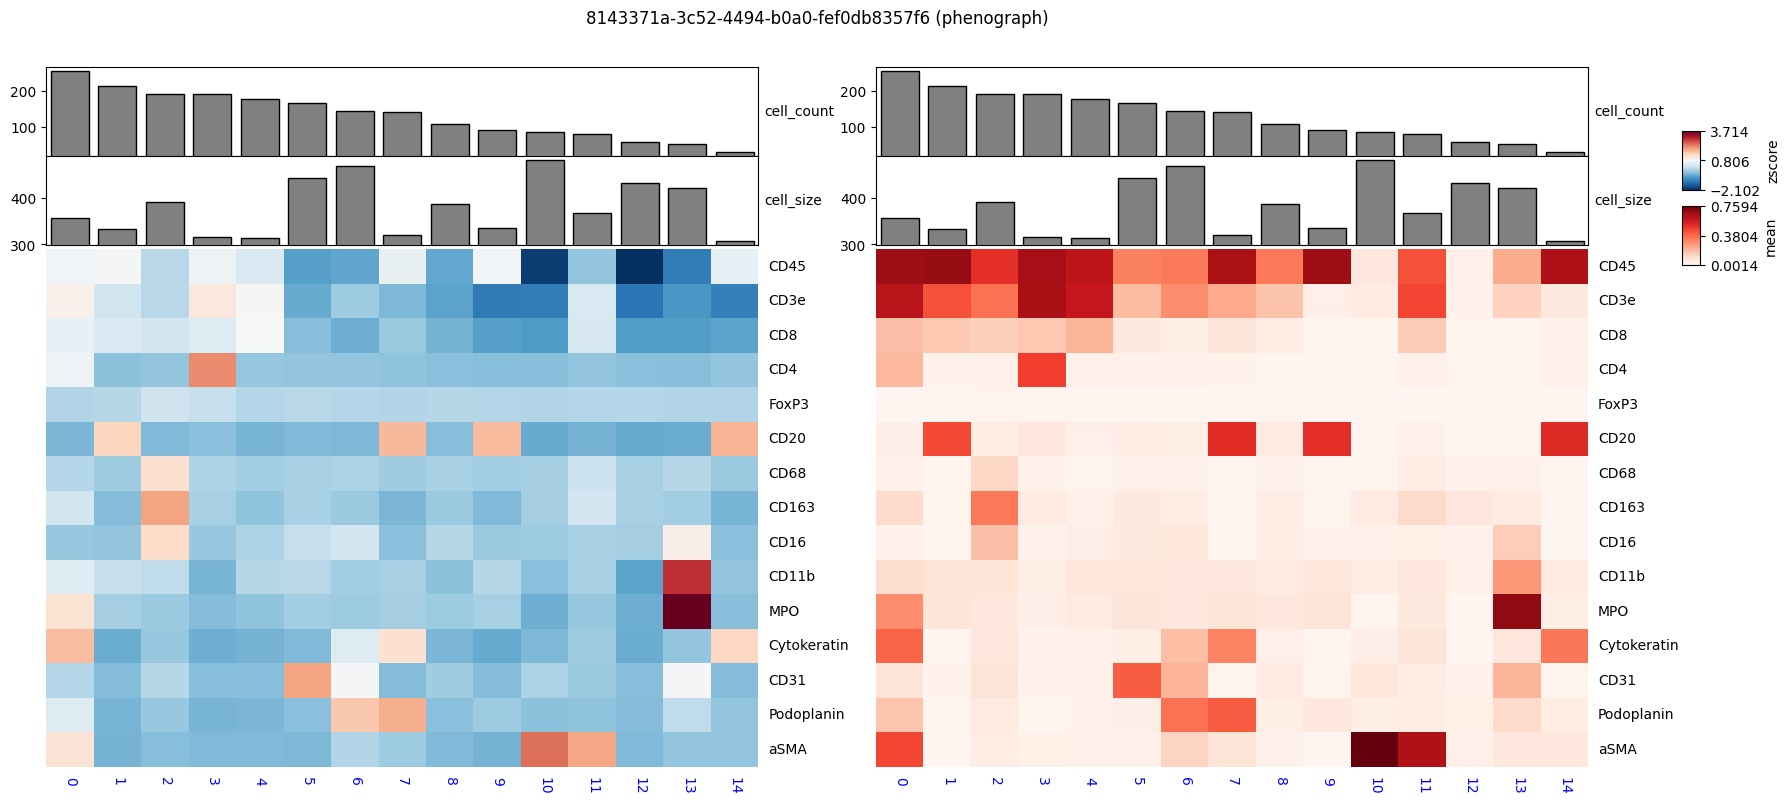

In [10]:
# plot heatmap without value limit
features = markers_all  # markers for visualization (not necessary to be the same as clustering)
plot_clustering_heatmap_2(
    adata,
    clustering_result,
    features,
    col_cellsize="cell_size",
    figsize=(20, 8),
    col_gap=30,
    legend_hpad=60,
)

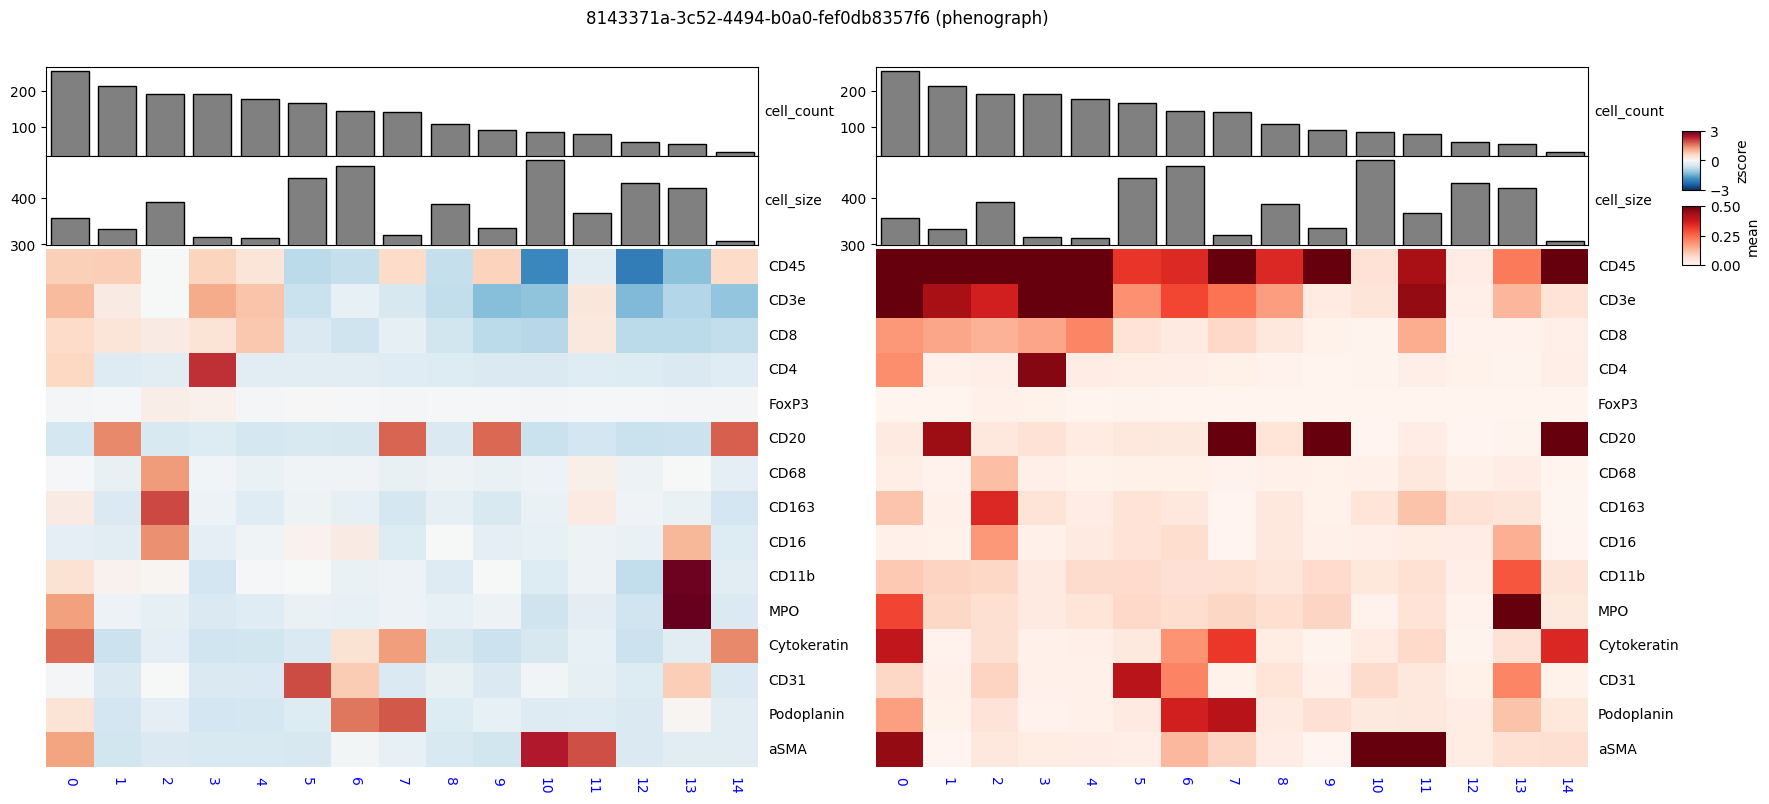

In [11]:
# plot heatmap with value limit, and turn off column clustering
features = markers_all  # markers for visualization (not necessary to be the same as clustering)
non_col_cluster = {"col_cluster": False, "col_dendrogram": False}
plot_clustering_heatmap_2(
    adata,
    clustering_result,
    features,
    col_cellsize="cell_size",
    figsize=(20, 8),
    col_gap=30,
    legend_hpad=60,
    kwargs_zscore={"vmin": -3, "center": 0, "vmax": 3} | non_col_cluster,
    kwargs_mean={"vmin": 0, "vmax": 0.5} | non_col_cluster,
)

In [12]:
# check whether cells of a core are involved in the clustering
# the cell_labels are unit_ids removed with the unit_id_prefix, which is integer part of the unit_id
# e.g., unit_id = RCC-TMA609(reg_4x5)-dst=reg019-src=reg005_c1 -> cell_label = 1

unit_id_prefix = "RCC-TMA609(reg_4x5)-dst=reg019-src=reg005_c"

n_match = len(
    [
        unit_id
        for unit_id in clustering_result.unit_ids
        if unit_id.startswith(unit_id_prefix)
    ]
)
if n_match > 0:
    print(f"Found {n_match} units starting with {unit_id_prefix} in this clustering")
else:
    print(f"No unit found starting with '{unit_id_prefix} in this clustering")

Found 2000 units starting with RCC-TMA609(reg_4x5)-dst=reg019-src=reg005_c in this clustering


In [13]:
# generate geojson to visualize the clustering result
geojson_file = Path("input/segmentation_demo.geojson")

update_geojson_from_clustering_result(
    geojson_file, clustering_result, output_dir, unit_id_prefix=unit_id_prefix
)


/opt/miniforge3/envs/clustering_3.11/lib/python3.11/site-packages/tqdm_joblib/__init__.py:4: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


Skipped 0 geometries: 


In [14]:
# just for demo and randomly add some annotations and tags

# for explicit clusters, add annotation
# units with annotation will be skipped for next clustering
clustering_result.add_annotation(
    {
        "0": "Toss",
        "1": "Muscle-like",
        "2": "Muscle-like",
        "3": "M",
        "4": "T",
        "5": "Endothelial",
        "6": "Muscle-like",
        "7": "Muscle-like",
        "8": "T",
        "9": "T",
        "10": "T",
    },
)

# for non-explicit clusters, it is recommended to add tag
# tag will be helpful for selecting units for next clustering
clustering_result.add_tag(
    {"11": "T_M", "12": "T_Other", "13": "T_M", "14": "T_M"},
    tag_name="tag",
)

In [15]:
# If you need to leave and want to continue later, you can stash the clustering result temporarily
clustering_result.stash(output_dir=output_dir)

To reload the stashed clustering result:
ClusteringResult.pop(
    clustering_id='8143371a-3c52-4494-b0a0-fef0db8357f6',
    output_dir='output/clustering_demo'
)


In [17]:
# After stashing, you can pop the clustering result
clustering_result = ClusteringResult.pop(
    clustering_id="8143371a-3c52-4494-b0a0-fef0db8357f6",
    output_dir="output/clustering_demo",
)

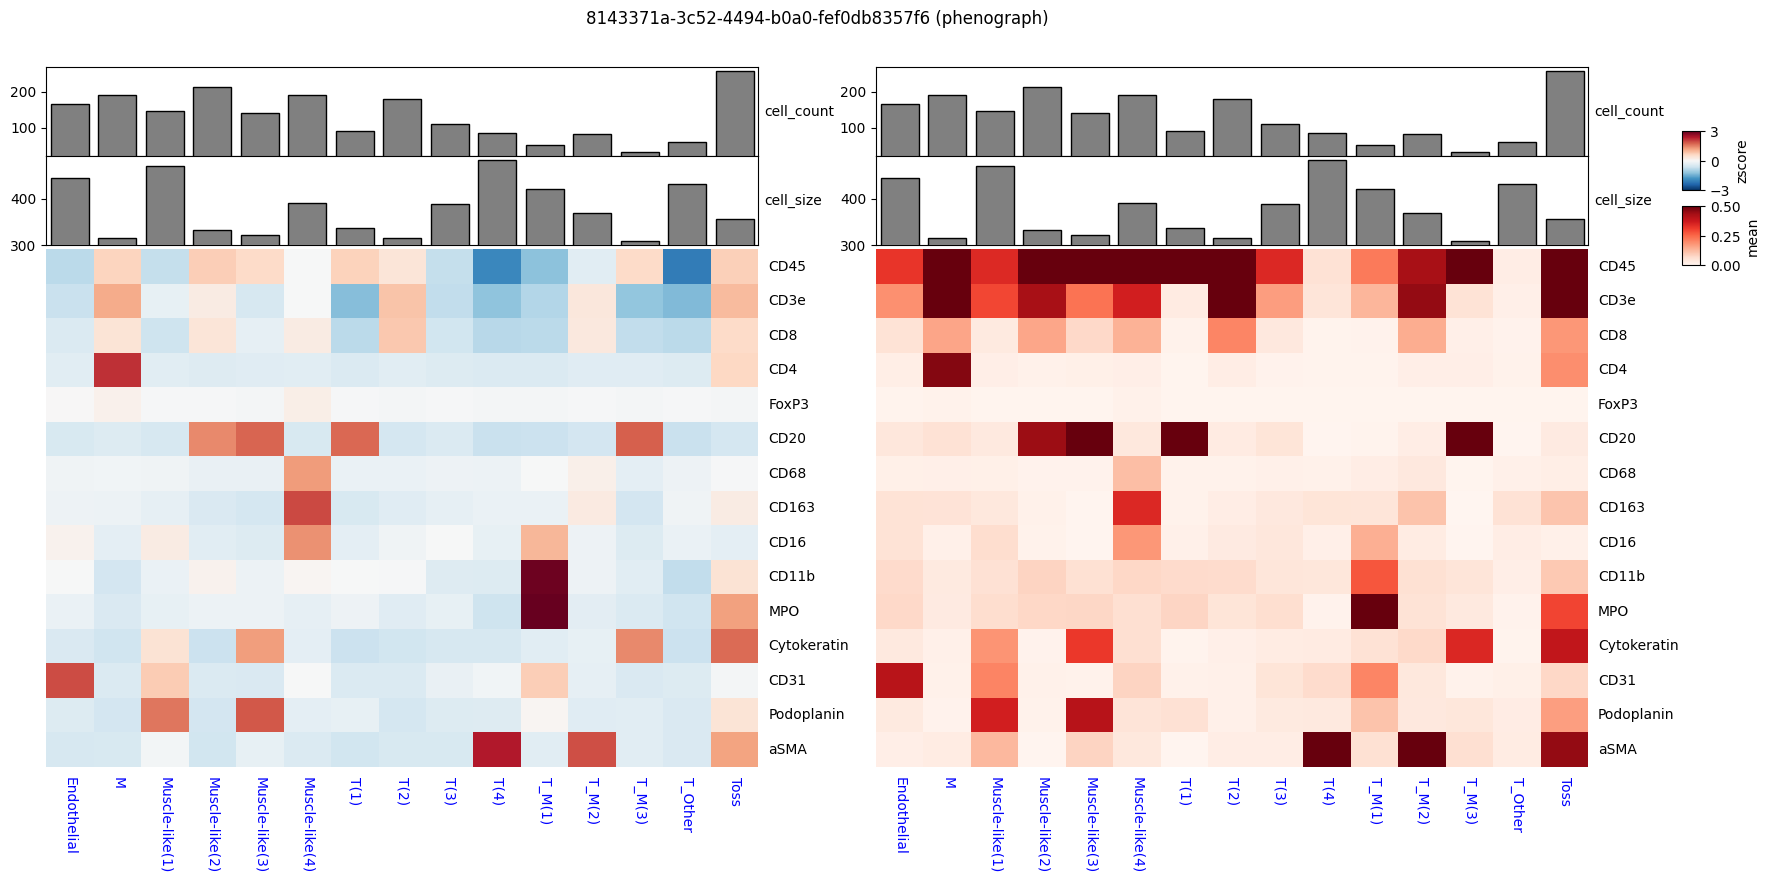

In [18]:
# plot heatmap with updated annotations and tags
features = markers_all  # markers for visualization (not necessary to be the same as clustering)
non_col_cluster = {"col_cluster": False, "col_dendrogram": False}
plot_clustering_heatmap_2(
    adata,
    clustering_result,
    features,
    col_cellsize="cell_size",
    figsize=(20, 8),
    x_label="tag",
    col_gap=30,
    legend_hpad=60,
    kwargs_zscore={"vmin": -3, "center": 0, "vmax": 3} | non_col_cluster,
    kwargs_mean={"vmin": 0, "vmax": 0.5} | non_col_cluster,
)


In [19]:
# save the clustering result if the annotation and tag are correct
clustering_result.save(output_dir)

# Subclustering 1

In [20]:
# use ClusteringResultManager to manage clustering results
manager = ClusteringResultManager(output_dir=output_dir, unit_ids=adata.obs.index)

# summary of clustering results
manager.summary_df

Loading clustering results: 100%|██████████████████████████████| 1/1 [00:00<00:00, 129.48it/s]


Processing annotations...


Processing tags: 100%|██████████████████████████████| 1/1 [00:00<00:00, 292.65it/s]


,annotation,clustering_id,tag
RCC-TMA609(reg_4x5)-dst=reg019-src=reg005_c24476,Muscle-like,8143371a-3c52-4494-b0a0-fef0db8357f6,
RCC-TMA609(reg_4x5)-dst=reg019-src=reg005_c37781,T,8143371a-3c52-4494-b0a0-fef0db8357f6,
RCC-TMA609(reg_4x5)-dst=reg019-src=reg005_c12264,T,8143371a-3c52-4494-b0a0-fef0db8357f6,
RCC-TMA609(reg_4x5)-dst=reg019-src=reg005_c51628,Toss,8143371a-3c52-4494-b0a0-fef0db8357f6,
RCC-TMA609(reg_4x5)-dst=reg019-src=reg005_c15057,Muscle-like,8143371a-3c52-4494-b0a0-fef0db8357f6,
...,...,...,...
RCC-TMA609(reg_4x5)-dst=reg019-src=reg005_c3327,T,8143371a-3c52-4494-b0a0-fef0db8357f6,
RCC-TMA609(reg_4x5)-dst=reg019-src=reg005_c16093,Muscle-like,8143371a-3c52-4494-b0a0-fef0db8357f6,
RCC-TMA609(reg_4x5)-dst=reg019-src=reg005_c24044,Muscle-like,8143371a-3c52-4494-b0a0-fef0db8357f6,
RCC-TMA609(reg_4x5)-dst=reg019-src=reg005_c50080,Toss,8143371a-3c52-4494-b0a0-fef0db8357f6,


In [21]:
# cells with no annotation need to be subclustered
manager.non_explicit_df

# tag will be helpful for selecting units for next clustering
manager.non_explicit_df.tag.value_counts()

# select units for next clustering
unit_ids = manager.non_explicit_df.query("tag == 'T_M'").index
unit_ids

,annotation,clustering_id,tag
RCC-TMA609(reg_4x5)-dst=reg019-src=reg005_c31238,,,T_M
RCC-TMA609(reg_4x5)-dst=reg019-src=reg005_c24774,,,T_M
RCC-TMA609(reg_4x5)-dst=reg019-src=reg005_c51832,,,T_M
RCC-TMA609(reg_4x5)-dst=reg019-src=reg005_c49944,,,T_M
RCC-TMA609(reg_4x5)-dst=reg019-src=reg005_c2453,,,T_M
...,...,...,...
RCC-TMA609(reg_4x5)-dst=reg019-src=reg005_c28293,,,T_M
RCC-TMA609(reg_4x5)-dst=reg019-src=reg005_c39104,,,T_M
RCC-TMA609(reg_4x5)-dst=reg019-src=reg005_c3411,,,T_Other
RCC-TMA609(reg_4x5)-dst=reg019-src=reg005_c3613,,,T_Other


tag
T_M        168
T_Other     60
Name: count, dtype: int64

Index(['RCC-TMA609(reg_4x5)-dst=reg019-src=reg005_c31238',
       'RCC-TMA609(reg_4x5)-dst=reg019-src=reg005_c24774',
       'RCC-TMA609(reg_4x5)-dst=reg019-src=reg005_c51832',
       'RCC-TMA609(reg_4x5)-dst=reg019-src=reg005_c49944',
       'RCC-TMA609(reg_4x5)-dst=reg019-src=reg005_c2453',
       'RCC-TMA609(reg_4x5)-dst=reg019-src=reg005_c37877',
       'RCC-TMA609(reg_4x5)-dst=reg019-src=reg005_c41323',
       'RCC-TMA609(reg_4x5)-dst=reg019-src=reg005_c19439',
       'RCC-TMA609(reg_4x5)-dst=reg019-src=reg005_c27838',
       'RCC-TMA609(reg_4x5)-dst=reg019-src=reg005_c12131',
       ...
       'RCC-TMA609(reg_4x5)-dst=reg019-src=reg005_c48061',
       'RCC-TMA609(reg_4x5)-dst=reg019-src=reg005_c35049',
       'RCC-TMA609(reg_4x5)-dst=reg019-src=reg005_c27534',
       'RCC-TMA609(reg_4x5)-dst=reg019-src=reg005_c37480',
       'RCC-TMA609(reg_4x5)-dst=reg019-src=reg005_c22140',
       'RCC-TMA609(reg_4x5)-dst=reg019-src=reg005_c4140',
       'RCC-TMA609(reg_4x5)-dst=reg019-src=reg0

In [22]:
# clustering using phenograph with T and Macrophage markers
clustering_result = run_clustering(
    adata,
    unit_ids,
    features=markers_t + markers_m,
    method="phenograph",
    method_params={"k": 50, "n_jobs": 8},
    output_dir=output_dir,  # automatically stash the clustering result at clustering
)
# clustering_result = ClusteringResult.from_csv("output/clustering_demo/clustering_results/adcb6652-72f1-4460-81d1-c78cf01c6429.csv")

Finding 50 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.013080358505249023 seconds
Jaccard graph constructed in 0.10025525093078613 seconds
Wrote graph to binary file in 0.0028276443481445312 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.509617
Louvain completed 21 runs in 0.07154202461242676 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 0.5033905506134033 seconds
To reload the stashed clustering result:
ClusteringResult.pop(
    clustering_id='0d9729c5-3b53-4aba-94a3-fae4869b2799',
    output_dir='output/clustering_demo'
)


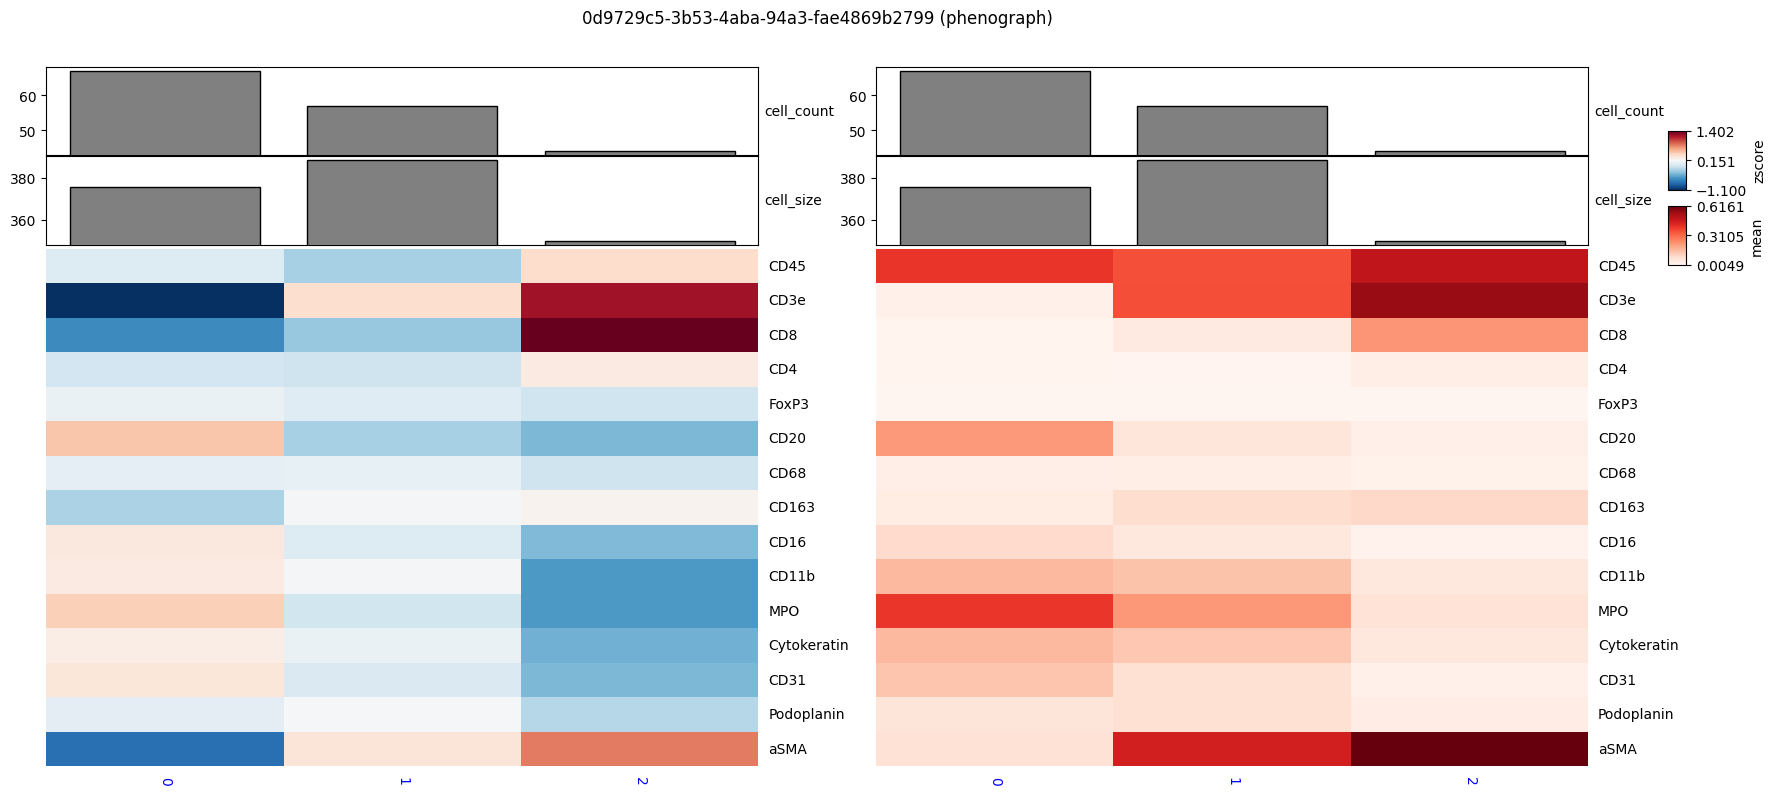

In [23]:
# plot heatmap without value limit
features = markers_all
plot_clustering_heatmap_2(
    adata,
    clustering_result,
    features,
    col_cellsize="cell_size",
    figsize=(20, 8),
)


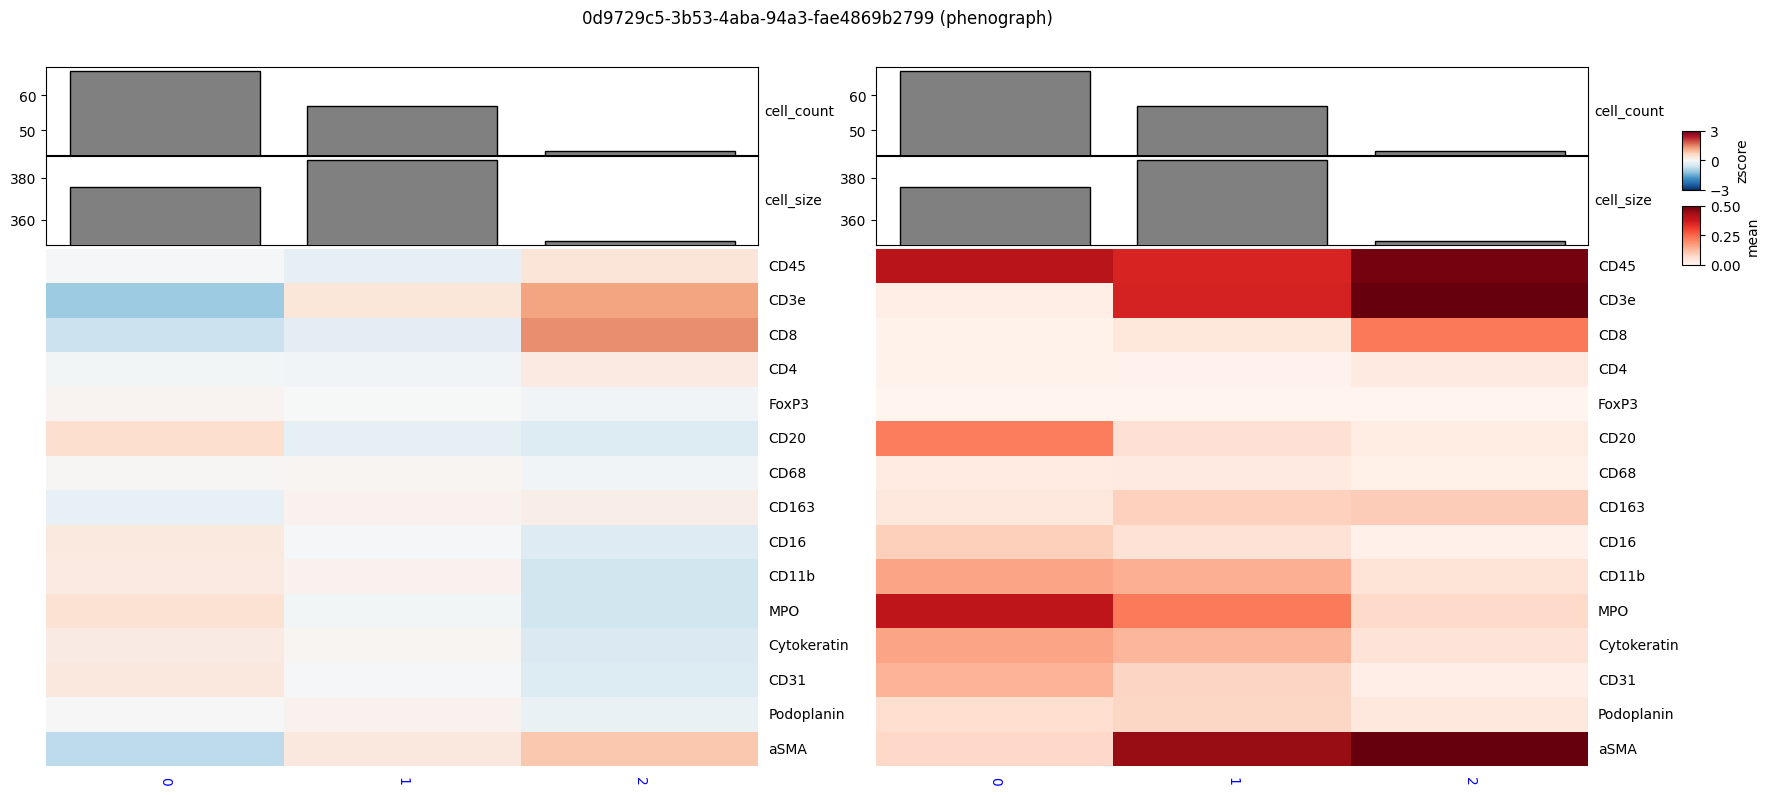

In [24]:
# plot heatmap with value limit
features = markers_all
non_col_cluster = {"col_cluster": False, "col_dendrogram": False}
plot_clustering_heatmap_2(
    adata,
    clustering_result,
    features,
    col_cellsize="cell_size",
    figsize=(20, 8),
    col_gap=30,
    legend_hpad=60,
    kwargs_zscore={"vmin": -3, "center": 0, "vmax": 3} | non_col_cluster,
    kwargs_mean={"vmin": 0, "vmax": 0.5} | non_col_cluster,
)


In [25]:
# just for demo and randomly add some annotations and tags

# add annotation
clustering_result.add_annotation(
    {"0": "CD8T", "1": "Neutrophil", "2": "CD8T"}
)

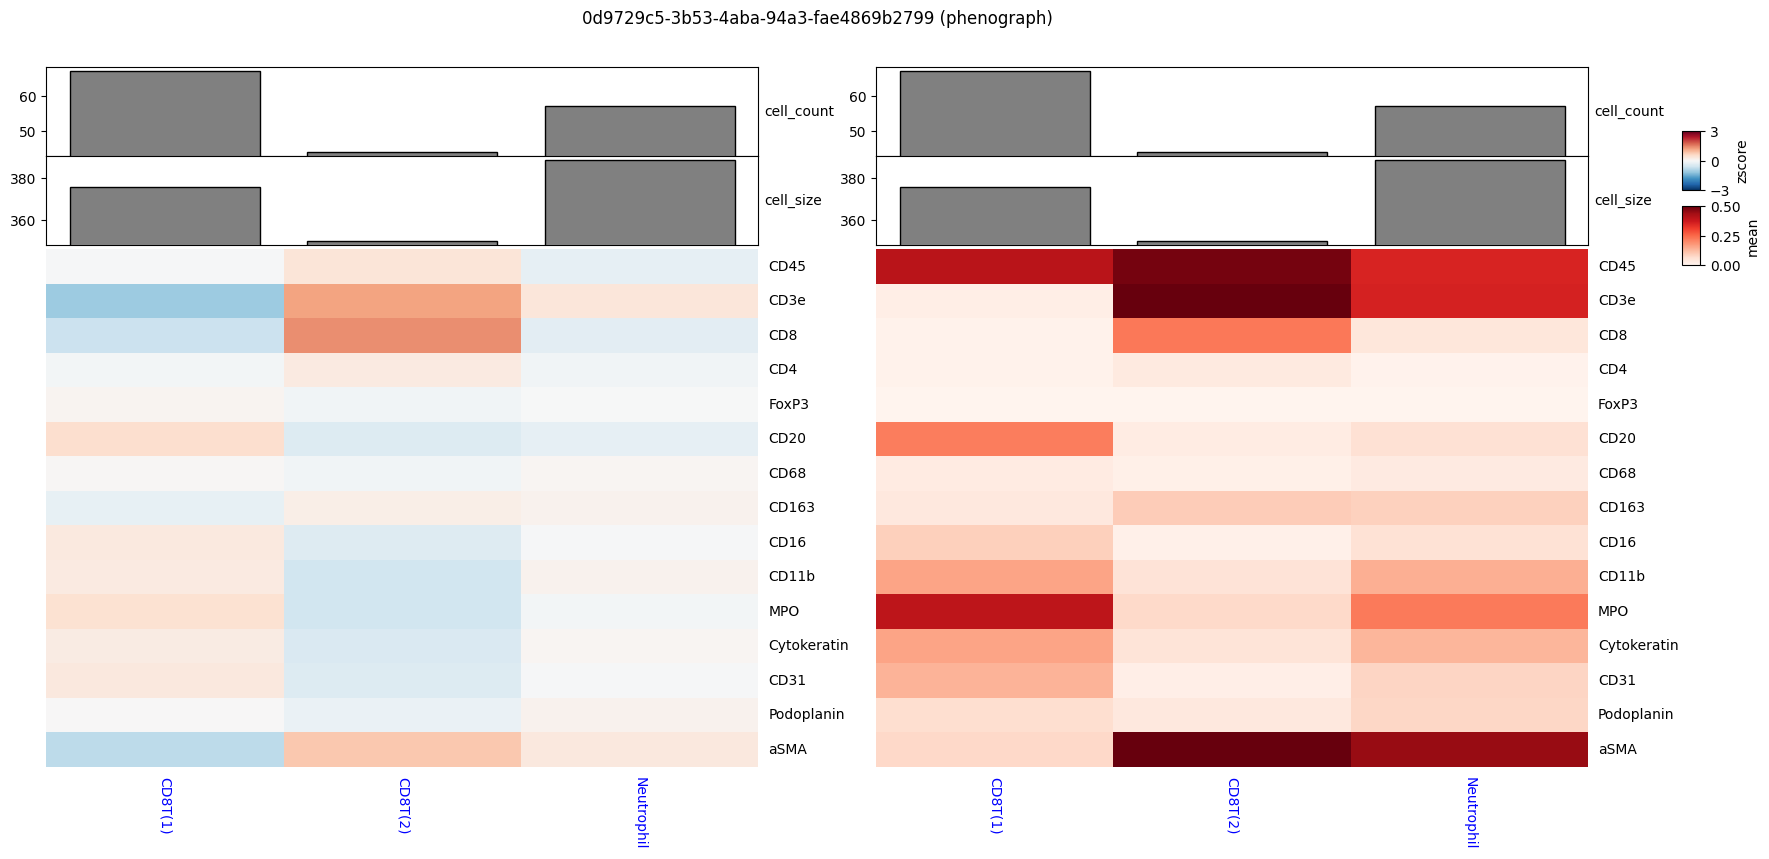

In [26]:
# plot heatmap with updated annotations
features = markers_all  # markers for visualization (not necessary to be the same as clustering)
non_col_cluster = {"col_cluster": False, "col_dendrogram": False}
plot_clustering_heatmap_2(
    adata,
    clustering_result,
    features,
    col_cellsize="cell_size",
    figsize=(20, 8),
    x_label="annotation",  # x_label can be "tag" or "annotation", if all units are annotated, use "annotation"
    col_gap=30,
    legend_hpad=60,
    kwargs_zscore={"vmin": -3, "center": 0, "vmax": 3} | non_col_cluster,
    kwargs_mean={"vmin": 0, "vmax": 0.5} | non_col_cluster,
)

In [27]:
# save the clustering result if the annotation and tag are correct
clustering_result.save(output_dir)

# Subclustering 2

In [28]:
# use ClusteringResultManager to manage clustering results
manager = ClusteringResultManager(output_dir=output_dir, unit_ids=adata.obs.index)

# cells with no annotation need to be subclustered
len(manager.non_explicit_df)
manager.non_explicit_df.tag.value_counts()

# select units for next clustering
unit_ids = manager.non_explicit_df.query("tag == 'T_Other'").index
unit_ids

Loading clustering results: 100%|██████████████████████████████| 2/2 [00:00<00:00, 153.80it/s]


Processing annotations...


Processing tags: 100%|██████████████████████████████| 1/1 [00:00<00:00, 295.83it/s]


60

tag
T_Other    60
Name: count, dtype: int64

Index(['RCC-TMA609(reg_4x5)-dst=reg019-src=reg005_c1967',
       'RCC-TMA609(reg_4x5)-dst=reg019-src=reg005_c32835',
       'RCC-TMA609(reg_4x5)-dst=reg019-src=reg005_c2822',
       'RCC-TMA609(reg_4x5)-dst=reg019-src=reg005_c5806',
       'RCC-TMA609(reg_4x5)-dst=reg019-src=reg005_c5274',
       'RCC-TMA609(reg_4x5)-dst=reg019-src=reg005_c18066',
       'RCC-TMA609(reg_4x5)-dst=reg019-src=reg005_c3467',
       'RCC-TMA609(reg_4x5)-dst=reg019-src=reg005_c6279',
       'RCC-TMA609(reg_4x5)-dst=reg019-src=reg005_c13226',
       'RCC-TMA609(reg_4x5)-dst=reg019-src=reg005_c6268',
       'RCC-TMA609(reg_4x5)-dst=reg019-src=reg005_c4828',
       'RCC-TMA609(reg_4x5)-dst=reg019-src=reg005_c1635',
       'RCC-TMA609(reg_4x5)-dst=reg019-src=reg005_c18580',
       'RCC-TMA609(reg_4x5)-dst=reg019-src=reg005_c24535',
       'RCC-TMA609(reg_4x5)-dst=reg019-src=reg005_c507',
       'RCC-TMA609(reg_4x5)-dst=reg019-src=reg005_c6119',
       'RCC-TMA609(reg_4x5)-dst=reg019-src=reg005_c37798',
       'R

In [29]:
# clustering using phenograph with T and B markers
clustering_result = run_clustering(
    adata,
    unit_ids,
    features=markers_nonimmune,
    method="phenograph",
    method_params={"k": 10, "n_jobs": 8},
    output_dir=output_dir,  # automatically stash the clustering result at clustering
)


Finding 10 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.012831926345825195 seconds
Jaccard graph constructed in 0.09127998352050781 seconds
Wrote graph to binary file in 0.0007927417755126953 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.582972
Louvain completed 21 runs in 0.06325340270996094 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 0.5039823055267334 seconds
To reload the stashed clustering result:
ClusteringResult.pop(
    clustering_id='610044af-cf53-40b8-91d8-6c2de019a8ae',
    output_dir='output/clustering_demo'
)


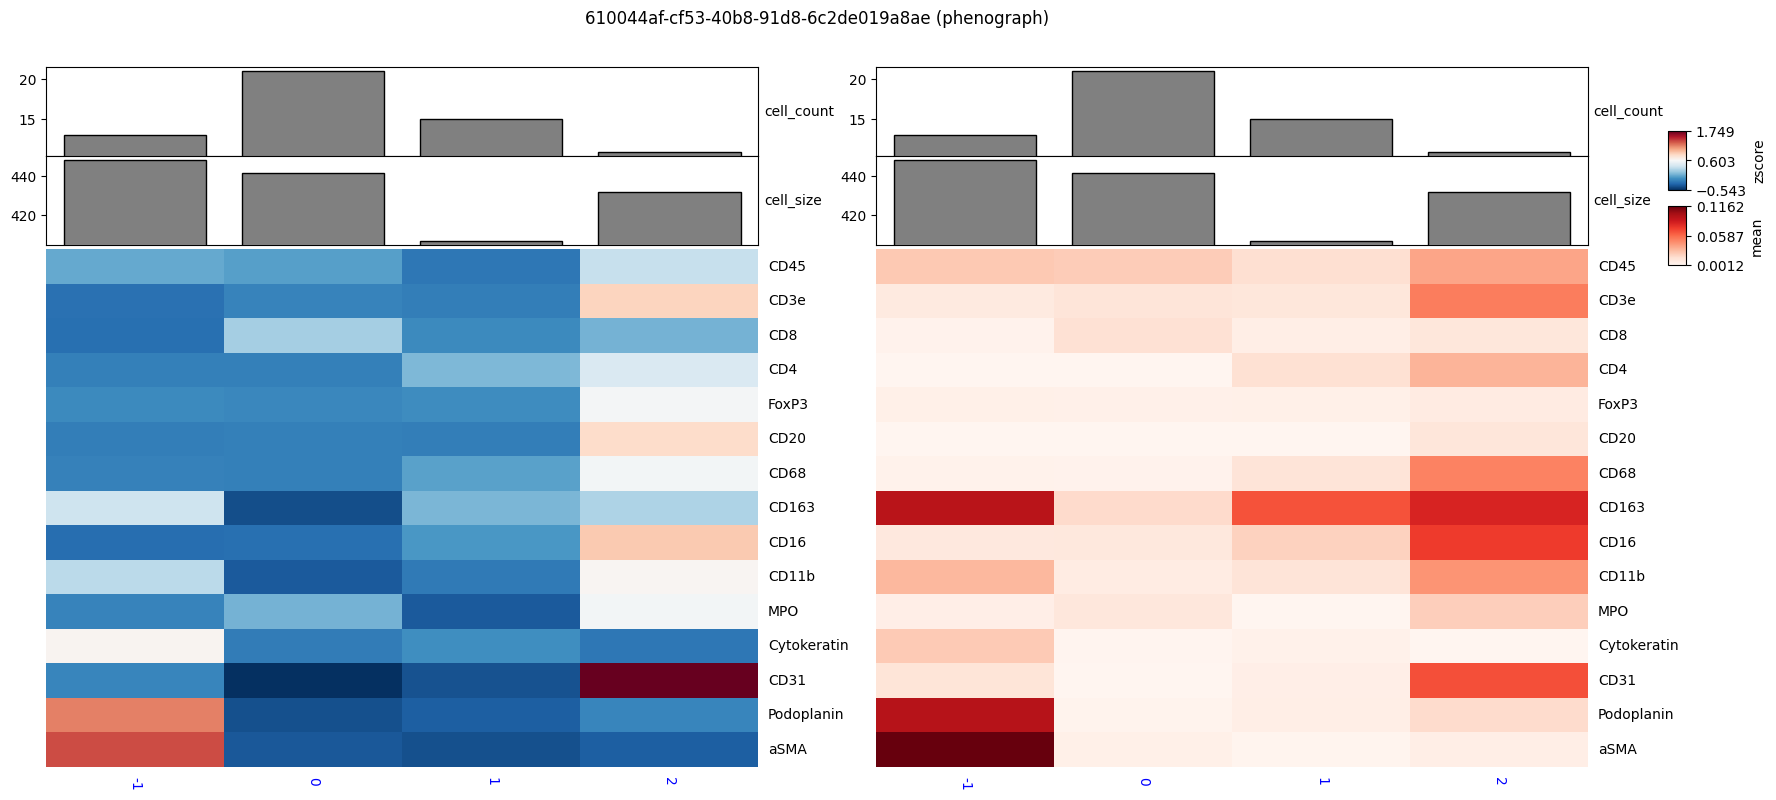

In [30]:
# plot heatmap without value limit
features = markers_all
plot_clustering_heatmap_2(
    adata,
    clustering_result,
    features,
    col_cellsize="cell_size",
    figsize=(20, 8),
    x_label="tag",
)


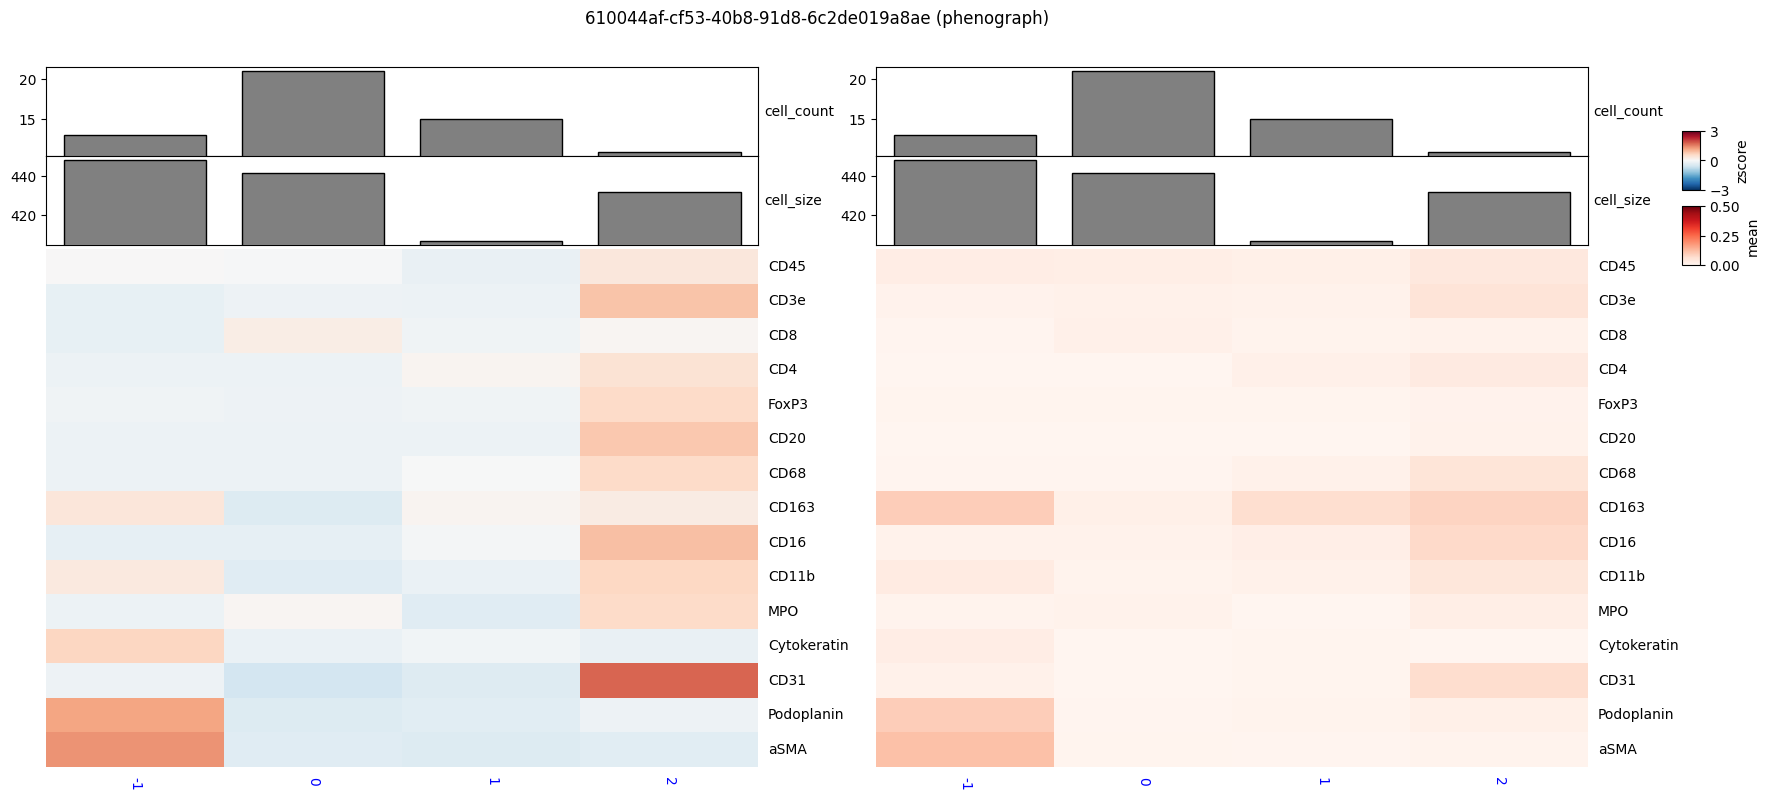

In [31]:
# plot heatmap with value limit
features = markers_all
non_col_cluster = {"col_cluster": False, "col_dendrogram": False}
plot_clustering_heatmap_2(
    adata,
    clustering_result,
    features,
    col_cellsize="cell_size",
    figsize=(20, 8),
    x_label="tag",
    col_gap=30,
    legend_hpad=60,
    kwargs_zscore={"vmin": -3, "center": 0, "vmax": 3} | non_col_cluster,
    kwargs_mean={"vmin": 0, "vmax": 0.5} | non_col_cluster,
)


In [32]:
# just for demo and randomly add some annotations and tags

# add annotation and tag
clustering_result.add_annotation({"0": "T", "1": "CD8T", "2": "Other"})

clustering_result.add_tag(
    {"-1": "T_Other"},
    tag_name="tag_2",  # you can use another tag name
)


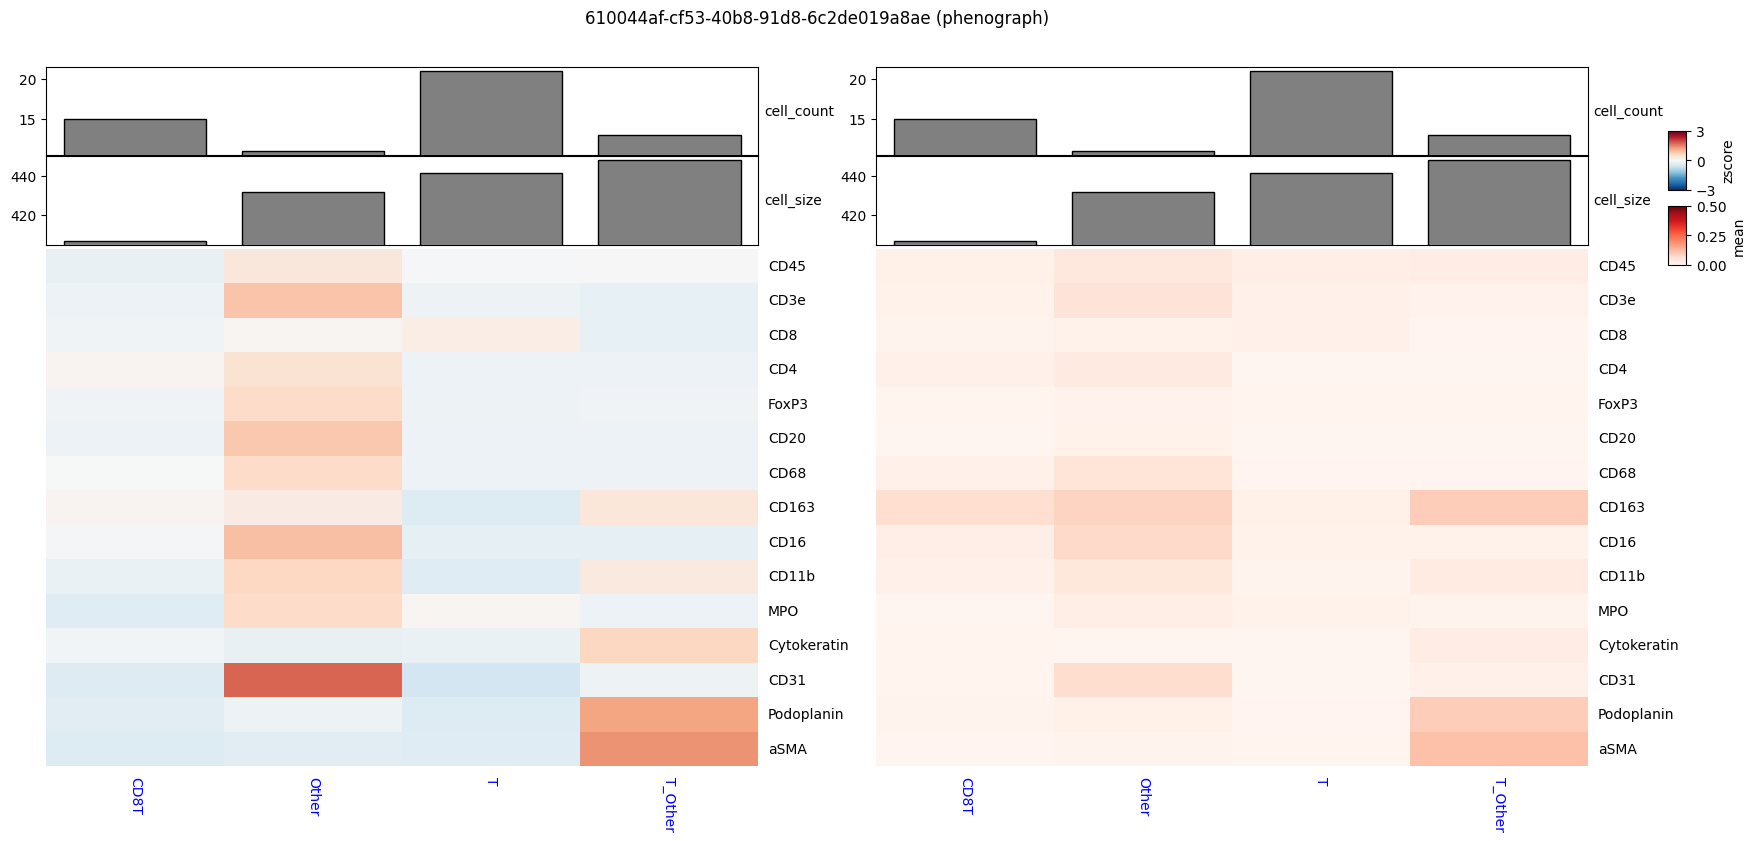

In [33]:
# plot heatmap with value limit
features = markers_all
non_col_cluster = {"col_cluster": False, "col_dendrogram": False}
plot_clustering_heatmap_2(
    adata,
    clustering_result,
    features,
    col_cellsize="cell_size",
    figsize=(20, 8),
    x_label="tag_2",
    kwargs_zscore={"vmin": -3, "center": 0, "vmax": 3} | non_col_cluster,
    kwargs_mean={"vmin": 0, "vmax": 0.5} | non_col_cluster,
)


In [34]:
clustering_result.save(output_dir)

# Final Heatmap


In [35]:
manager = ClusteringResultManager(output_dir=output_dir, unit_ids=adata.obs.index)
len(manager.non_explicit_df)

Loading clustering results: 100%|██████████████████████████████| 3/3 [00:00<00:00, 194.50it/s]


Processing annotations...


Processing tags: 100%|██████████████████████████████| 2/2 [00:00<00:00, 467.49it/s]


13

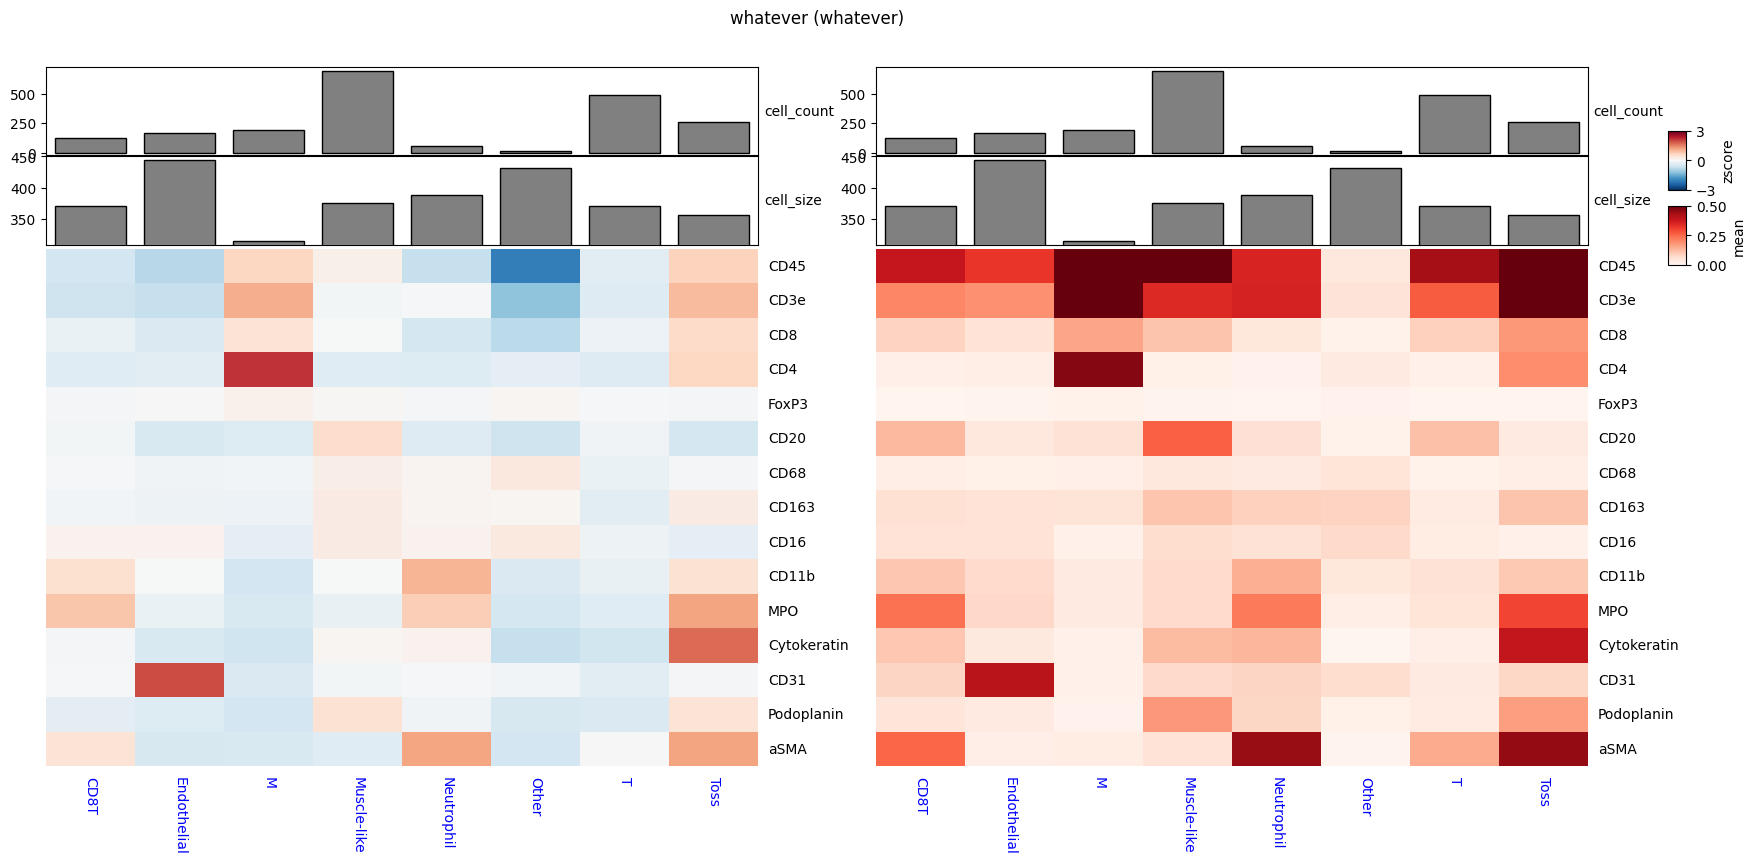

In [36]:
idx_annotated = manager.summary_df.annotation != ""
result = ClusteringResult(
    clustering_id="whatever",
    method="whatever",
    unit_ids=manager.summary_df.index[idx_annotated],
    cluster_ids=manager.summary_df.annotation[idx_annotated],
)
non_col_cluster = {"col_cluster": False, "col_dendrogram": False}
plot_clustering_heatmap_2(
    adata,
    result,
    features,
    col_cellsize="cell_size",
    figsize=(20, 8),
    x_label="annotation",
    kwargs_zscore={"vmin": -3, "center": 0, "vmax": 3} | non_col_cluster,
    kwargs_mean={"vmin": 0, "vmax": 0.5} | non_col_cluster,
)
